<a href="https://colab.research.google.com/github/Kyocera1303/Python_HW_2/blob/main/Data_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

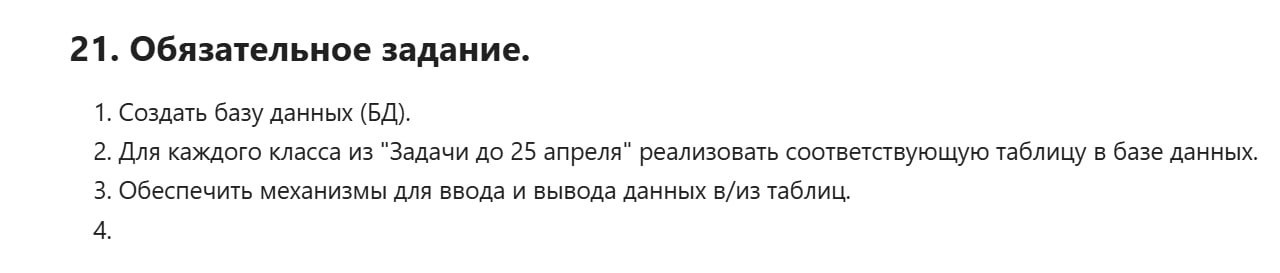

In [1]:
import sqlite3
from abc import ABC, abstractmethod
from typing import List

DB_PATH = 'tours.db'

def init_db(db_path: str = DB_PATH):
    """Инициализация базы данных и создание таблицы tours."""
    conn = sqlite3.connect(db_path)
    with conn:
        conn.execute("""
CREATE TABLE IF NOT EXISTS tours (
    tour_id        INTEGER PRIMARY KEY,
    destination    TEXT    NOT NULL,
    duration       INTEGER NOT NULL,
    price          REAL    NOT NULL,
    is_available   INTEGER NOT NULL,
    type           TEXT    NOT NULL,
    visa_fee       REAL
)
""")
    conn.close()


# === Исключения ===
class TourServiceError(Exception):
    pass

class TourNotFoundError(TourServiceError):
    pass

class InvalidTourDataError(TourServiceError):
    pass


# === Миксины ===
class LoggingMixin:
    def log(self, message: str):
        print(f"[LOG] {message}")

class NotificationMixin:
    def notify(self, message: str):
        print(f"[NOTIFICATION] {message}")


# === Абстрактный класс Tour ===
class Tour(ABC):
    def __init__(
        self,
        tour_id: int,
        destination: str,
        duration: int,
        price: float,
        is_available: bool = True
    ):
        if not destination:
            raise InvalidTourDataError("Направление не может быть пустым.")
        if duration <= 0:
            raise InvalidTourDataError("Продолжительность должна быть > 0.")
        if price <= 0:
            raise InvalidTourDataError("Цена должна быть > 0.")
        self.__tour_id = tour_id
        self.__destination = destination
        self.__duration = duration
        self.__price = price
        self.__is_available = is_available

    @abstractmethod
    def calculate_cost(self) -> float:
        """Вычислить полную стоимость тура."""
        pass

    # Геттеры / сеттеры
    def get_id(self) -> int:
        return self.__tour_id

    def get_destination(self) -> str:
        return self.__destination

    def set_destination(self, dest: str):
        if not dest:
            raise InvalidTourDataError("Направление не может быть пустым.")
        self.__destination = dest

    def get_duration(self) -> int:
        return self.__duration

    def set_duration(self, dur: int):
        if dur <= 0:
            raise InvalidTourDataError("Продолжительность должна быть > 0.")
        self.__duration = dur

    def get_price(self) -> float:
        return self.__price

    def set_price(self, pr: float):
        if pr <= 0:
            raise InvalidTourDataError("Цена должна быть > 0.")
        self.__price = pr

    def is_available(self) -> bool:
        return self.__is_available

    def set_availability(self, avail: bool):
        self.__is_available = avail

    def __str__(self):
        return (f"Тур (ID {self.get_id()}): {self.get_destination()}, "
                f"{self.get_duration()} дней, {self.get_price()} руб")

    def __lt__(self, other):
        if not isinstance(other, Tour):
            return NotImplemented
        if self.get_price() == other.get_price():
            return self.get_duration() < other.get_duration()
        return self.get_price() < other.get_price()

    def __gt__(self, other):
        if not isinstance(other, Tour):
            return NotImplemented
        if self.get_price() == other.get_price():
            return self.get_duration() > other.get_duration()
        return self.get_price() > other.get_price()


# === Конкретные туры ===
class DomesticTour(Tour):
    def calculate_cost(self) -> float:
        return self.get_price() * self.get_duration()

class InternationalTour(Tour):
    def __init__(
        self,
        tour_id: int,
        destination: str,
        duration: int,
        price: float,
        visa_fee: float,
        is_available: bool = True
    ):
        super().__init__(tour_id, destination, duration, price, is_available)
        if visa_fee < 0:
            raise InvalidTourDataError("Виза: сбор не может быть < 0.")
        self.__visa_fee = visa_fee


    def calculate_cost(self) -> float:
        return self.get_price() * self.get_duration() + self.__visa_fee

    def get_visa_fee(self) -> float:
        return self.__visa_fee

    def __str__(self):
        return super().__str__() + f", виза: {self.__visa_fee} руб"


# === Сервис управления турами с БД ===
class TourService(LoggingMixin, NotificationMixin):
    def __init__(self, db_path: str = DB_PATH):
        self.db_path = db_path
        init_db(self.db_path)

    def _connect(self):
        return sqlite3.connect(self.db_path)

    def add_tour(self, tour: Tour):
        if not isinstance(tour, Tour):
            raise InvalidTourDataError("Можно добавлять только Tour.")
        conn = self._connect()
        with conn:
            conn.execute(
                "INSERT INTO tours (tour_id, destination, duration, price, is_available, type, visa_fee) "
                "VALUES (?, ?, ?, ?, ?, ?, ?)",
                (
                    tour.get_id(),
                    tour.get_destination(),
                    tour.get_duration(),
                    tour.get_price(),
                    int(tour.is_available()),
                    type(tour).__name__,
                    getattr(tour, "get_visa_fee", lambda: None)()
                )
            )
        conn.close()
        self.log(f"Добавлен тур: {tour}")
        self.notify(f"Новый тур: {tour}")

    def edit_tour(self, tour_id: int, **kwargs):
        # ищем и изменяем в памяти, затем сохраняем
        tours = self.get_all_tours()
        tour = next((t for t in tours if t.get_id() == tour_id), None)
        if tour is None:
            raise TourNotFoundError(f"Тур {tour_id} не найден.")
        if "destination" in kwargs:
            tour.set_destination(kwargs["destination"])
        if "duration" in kwargs:
            tour.set_duration(kwargs["duration"])
        if "price" in kwargs:
            tour.set_price(kwargs["price"])
        if "is_available" in kwargs:
            tour.set_availability(kwargs["is_available"])
        conn = self._connect()
        with conn:
            conn.execute("""
                UPDATE tours
                   SET destination=?, duration=?, price=?, is_available=?
                 WHERE tour_id=?
            """, (
                tour.get_destination(),
                tour.get_duration(),
                tour.get_price(),
                int(tour.is_available()),
                tour_id
            ))
        conn.close()
        self.log(f"Изменён тур ID {tour_id}")
        self.notify(f"Тур обновлён: {tour}")

    def delete_tour(self, tour_id: int):
        conn = self._connect()
        with conn:
            cur = conn.execute("SELECT destination FROM tours WHERE tour_id=?", (tour_id,))
            row = cur.fetchone()
            if not row:
                raise TourNotFoundError(f"Тур {tour_id} не найден.")
            conn.execute("DELETE FROM tours WHERE tour_id=?", (tour_id,))
        conn.close()
        self.log(f"Удалён тур ID {tour_id}: {row[0]}")
        self.notify(f"Тур удалён ID {tour_id}")

    def get_all_tours(self) -> List[Tour]:
        conn = self._connect()
        cur = conn.cursor()
        cur.execute("SELECT tour_id, destination, duration, price, is_available, type, visa_fee FROM tours")
        rows = cur.fetchall()
        conn.close()

        tours: List[Tour] = []
        for tid, dest, dur, pr, avail, ttype, vf in rows:
            if ttype == "InternationalTour":
                tours.append(InternationalTour(tid, dest, dur, pr, vf, bool(avail)))
            else:
                tours.append(DomesticTour(tid, dest, dur, pr, bool(avail)))
        return tours


    def search_by_destination(self, substr: str) -> List[Tour]:
        conn = self._connect()
        cur = conn.cursor()
        pattern = "%" + substr.lower() + "%"
        cur.execute("""
            SELECT tour_id, destination, duration, price, is_available, type, visa_fee
              FROM tours
             WHERE LOWER(destination) LIKE ?
        """, (pattern,))
        rows = cur.fetchall()
        conn.close()

        result: List[Tour] = []
        for tid, dest, dur, pr, avail, ttype, vf in rows:
            if ttype == "InternationalTour":
                result.append(InternationalTour(tid, dest, dur, pr, vf, bool(avail)))
            else:
                result.append(DomesticTour(tid, dest, dur, pr, bool(avail)))
        return result

    def analyze_data(self):
        tours = self.get_all_tours()
        total = len(tours)
        available = sum(t.is_available() for t in tours)
        average_cost = sum(t.calculate_cost() for t in tours) / total if total else 0
        return {
            "total_tours": total,
            "available_tours": available,
            "average_cost": average_cost
        }


if __name__ == "__main__":
    service = TourService()

    # Пример использования
    t1 = DomesticTour(1, "Москва",    3, 150.0)
    t2 = InternationalTour(2, "Париж", 5, 200.0, visa_fee=80.0)

    service.add_tour(t1)
    service.add_tour(t2)

    # Редактирование
    service.edit_tour(1, price=180.0, is_available=False)

    # Вывод всех туров
    print("\nВсе туры:")
    for tour in service.get_all_tours():
        print(tour, "- Стоимость:", tour.calculate_cost())

    # Поиск по направлению
    print("\nПоиск по 'пар':")
    for tour in service.search_by_destination("пар"):
        print(tour, "- Стоимость:", tour.calculate_cost())

    # Анализ данных
    print("\nСтатистика:", service.analyze_data())


[LOG] Добавлен тур: Тур (ID 1): Москва, 3 дней, 150.0 руб
[NOTIFICATION] Новый тур: Тур (ID 1): Москва, 3 дней, 150.0 руб
[LOG] Добавлен тур: Тур (ID 2): Париж, 5 дней, 200.0 руб, виза: 80.0 руб
[NOTIFICATION] Новый тур: Тур (ID 2): Париж, 5 дней, 200.0 руб, виза: 80.0 руб
[LOG] Изменён тур ID 1
[NOTIFICATION] Тур обновлён: Тур (ID 1): Москва, 3 дней, 180.0 руб

Все туры:
Тур (ID 1): Москва, 3 дней, 180.0 руб - Стоимость: 540.0
Тур (ID 2): Париж, 5 дней, 200.0 руб, виза: 80.0 руб - Стоимость: 1080.0

Поиск по 'пар':

Статистика: {'total_tours': 2, 'available_tours': 1, 'average_cost': 810.0}


ЗАДАНИЯ 1-20

In [2]:
import sqlite3
import os
from datetime import datetime

if os.path.exists('library.db'):
    os.remove('library.db')

conn = sqlite3.connect('library.db')
cursor = conn.cursor()

# === 1. Создание таблицы books ===
cursor.execute('''
CREATE TABLE IF NOT EXISTS books (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT NOT NULL,
    author TEXT NOT NULL,
    year_published INTEGER,
    genre TEXT
)
''')

# === 2. Вставка данных ===
books_data = [
    ("The Great Gatsby", "F. Scott Fitzgerald", 1925, "Fiction"),
    ("1984", "George Orwell", 1949, "Dystopian"),
    ("To Kill a Mockingbird", "Harper Lee", 1960, "Classic")
]
cursor.executemany('''
INSERT INTO books (title, author, year_published, genre) VALUES (?, ?, ?, ?)
''', books_data)

# === 3. Выборка всех данных ===
cursor.execute('SELECT * FROM books')
print("Все книги:")
for row in cursor.fetchall():
    print(row)

# === 4. Фильтрация данных (>1950 года) ===
cursor.execute('SELECT * FROM books WHERE year_published > 1950')
print("\nКниги, опубликованные после 1950 года:")
for row in cursor.fetchall():
    print(row)

# === 5. Использование оператора LIKE (названия начинаются с "T") ===
cursor.execute('SELECT * FROM books WHERE title LIKE "T%"')
print("\nКниги, название которых начинается с 'T':")
for row in cursor.fetchall():
    print(row)

# === 6. Сортировка данных (по году публикации) ===
cursor.execute('SELECT * FROM books ORDER BY year_published ASC')
print("\nКниги, отсортированные по году публикации:")
for row in cursor.fetchall():
    print(row)

# === 7. Ограничение количества строк (первые две книги, отсортированные по названию) ===
cursor.execute('SELECT * FROM books ORDER BY title LIMIT 2')
print("\nПервые две книги, отсортированные по названию:")
for row in cursor.fetchall():
    print(row)

# === 8. Агрегатные функции (общее количество книг) ===
cursor.execute('SELECT COUNT(*) FROM books')
total_books = cursor.fetchone()[0]
print(f"\nОбщее количество книг: {total_books}")

# === 9. Группировка данных (количество книг для каждого жанра) ===
cursor.execute('SELECT genre, COUNT(*) FROM books GROUP BY genre')
print("\nКоличество книг для каждого жанра:")
for row in cursor.fetchall():
    print(row)

# === 10. Обновление данных (обновить год публикации книги "1984" на "1948") ===
cursor.execute('UPDATE books SET year_published = 1948 WHERE title = "1984"')

# === 11. Удаление данных (удалить книгу "The Great Gatsby") ===
cursor.execute('DELETE FROM books WHERE title = "The Great Gatsby"')

# === 12. Создание индекса (для столбца author) ===
cursor.execute('CREATE INDEX IF NOT EXISTS idx_author ON books(author)')

# === 13. Проверка существования индекса ===
cursor.execute("SELECT name FROM sqlite_master WHERE type='index' AND name='idx_author'")
index_exists = cursor.fetchone()
print(f"\nИндекс для столбца author {'существует' if index_exists else 'не существует'}.")

# === 14. Триггер для логирования ===
cursor.execute('''
CREATE TABLE IF NOT EXISTS logs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    message TEXT
)
''')
cursor.execute('''
CREATE TRIGGER IF NOT EXISTS log_insert AFTER INSERT ON books
BEGIN
    INSERT INTO logs (message) VALUES ('Добавлена новая книга: ' || NEW.title);
END;
''')

# === 15. Транзакции ===
try:
    conn.execute('BEGIN TRANSACTION')
    # Добавление новой книги
    cursor.execute('INSERT INTO books (title, author, year_published, genre) VALUES (?, ?, ?, ?)',
                   ("New Book", "Author Name", 2023, "Fantasy"))
    # Обновление года публикации другой книги
    cursor.execute('UPDATE books SET year_published = 1961 WHERE title = "To Kill a Mockingbird"')
    # Отмена изменений (раскомментируйте следующую строку для отмены транзакции)
    # raise Exception("Ошибка транзакции!")
    conn.commit()
except Exception as e:
    conn.rollback()
    print(f"Транзакция отменена: {e}")

# === 16. Возраст книги ===
def book_age(year_published):
    current_year = datetime.now().year
    return current_year - year_published


conn.create_function("book_age", 1, book_age)
cursor.execute('SELECT title, book_age(year_published) AS age FROM books')
print("\nВозраст книг:")
for row in cursor.fetchall():
    print(row)

# === 17. Представления ===
cursor.execute('''
CREATE VIEW IF NOT EXISTS modern_books AS
SELECT * FROM books WHERE year_published > 1950
''')

# === 18. Удаление таблицы и проверка её существования ===
cursor.execute('DROP TABLE IF EXISTS books')
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='books'")
table_exists = cursor.fetchone()
print(f"\nТаблица books {'существует' if table_exists else 'не существует'}.")

# Пересоздаем таблицу books, если она была удалена
cursor.execute('''
CREATE TABLE IF NOT EXISTS books (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT NOT NULL,
    author TEXT NOT NULL,
    year_published INTEGER,
    genre TEXT
)
''')

# Вставляем данные заново (если таблица была удалена)
books_data = [
    ("The Great Gatsby", "F. Scott Fitzgerald", 1925, "Fiction"),
    ("1984", "George Orwell", 1949, "Dystopian"),
    ("To Kill a Mockingbird", "Harper Lee", 1960, "Classic")
]
cursor.executemany('''
INSERT INTO books (title, author, year_published, genre) VALUES (?, ?, ?, ?)
''', books_data)

# === 19. Композитный индекс ===
cursor.execute('CREATE INDEX IF NOT EXISTS idx_author_year ON books(author, year_published)')
print("\nКомпозитный индекс создан.")

# === 20. Удаление базы данных ===
conn.close()
import os
if os.path.exists('library.db'):
    os.remove('library.db')
    print("\nБаза данных library.db удалена.")
else:
    print("\nБаза данных library.db не найдена.")


Все книги:
(1, 'The Great Gatsby', 'F. Scott Fitzgerald', 1925, 'Fiction')
(2, '1984', 'George Orwell', 1949, 'Dystopian')
(3, 'To Kill a Mockingbird', 'Harper Lee', 1960, 'Classic')

Книги, опубликованные после 1950 года:
(3, 'To Kill a Mockingbird', 'Harper Lee', 1960, 'Classic')

Книги, название которых начинается с 'T':
(1, 'The Great Gatsby', 'F. Scott Fitzgerald', 1925, 'Fiction')
(3, 'To Kill a Mockingbird', 'Harper Lee', 1960, 'Classic')

Книги, отсортированные по году публикации:
(1, 'The Great Gatsby', 'F. Scott Fitzgerald', 1925, 'Fiction')
(2, '1984', 'George Orwell', 1949, 'Dystopian')
(3, 'To Kill a Mockingbird', 'Harper Lee', 1960, 'Classic')

Первые две книги, отсортированные по названию:
(2, '1984', 'George Orwell', 1949, 'Dystopian')
(1, 'The Great Gatsby', 'F. Scott Fitzgerald', 1925, 'Fiction')

Общее количество книг: 3

Количество книг для каждого жанра:
('Classic', 1)
('Dystopian', 1)
('Fiction', 1)

Индекс для столбца author существует.
Транзакция отменена: canno